In [20]:
import pandas as pd
import torch
import torch.nn as nn
from d2l import torch as d2l

In [21]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

In [22]:
# Accessing and Reading the Dataset
# If the dataset already exists in the cache directory, our code will use the cached file

class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                                                      sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                                                    sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [23]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [24]:
# Looking at the first five examples

print(data.raw_train.iloc[:5, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
4   5          60       RL         84.0       WD        Normal     250000


In [25]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    
    # Removing the Id and SalePrice columns
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', 'SalePrice']), # We are predicting the price so not including in features
         self.raw_val.drop(columns=['Id'])))
    
    # Standaridizing the numerical columns
    numeric_features = features.dtypes[features.dtypes != 'object'].index
    features[numeric_features] = features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std())) 
    
    # Replacing the NAN by 0
    features[numeric_features] = features[numeric_features].fillna(0)

    # Replacing discrete features by one hot encoding
    features = pd.get_dummies(features, dummy_na=True)

    # Finally saving the preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train['SalePrice'] = self.raw_train['SalePrice']
    self.val = features[self.raw_train.shape[0]:].copy()

In [26]:
data.preprocess()
data.train.shape

(1460, 331)

In [31]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float), dtype=torch.float32)

    tensors = (get_tensor(data.drop(columns = [label])),
               torch.log(get_tensor(data[label])).reshape((-1, 1)))
    return self.get_tensorloader(tensors, train)

In [32]:
# K-Fold Cross Validation

def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

In [33]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

/home/drishya/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/drishya/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/drishya/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/drishya/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning

average validation log mse = 0.18433380007743833


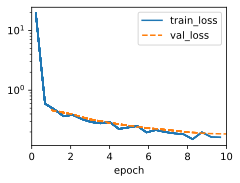

In [34]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

In [37]:
# Using learning_rates to perform a grid search
# It keeps track of the best model and its corresponding validation loop
# It prints the best learning rate and validation loss, and returns the best model

def k_fold(trainer, data, k, learning_rates):
    val_losses = []
    best_val_loss = float('inf')
    best_model = None

    for lr in learning_rates:
        fold_val_losses = []
        for i, data_fold in enumerate(k_fold_data(data, k)):
            model = d2l.LinearRegression(lr)
            model.board.yscale = 'log'
            if i != 0: model.board.display = False
            trainer.fit(model, data_fold)
            fold_val_losses.append(float(model.board.data['val_loss'][-1].y))

        avg_val_loss = sum(fold_val_losses) / len(fold_val_losses)
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model

    d2l.plot(learning_rates, val_losses, 'lr', 'val_loss', 'Learning Rate vs. Validation Loss')

    print(f'Best Learning Rate: {best_model.lr}')
    print(f'Best Validation Loss: {best_val_loss}')

    return best_model

/home/drishya/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/drishya/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/drishya/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/drishya/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning

Best Learning Rate: 0.01
Best Validation Loss: 0.16392591670155526


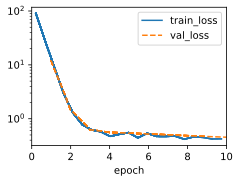

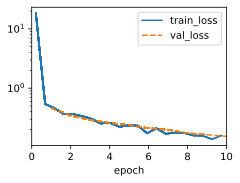

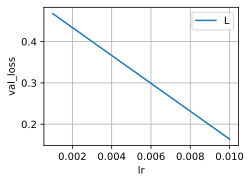

In [38]:
trainer = d2l.Trainer(max_epochs=10)
best_model = k_fold(trainer, data, k=10, learning_rates=[0.001, 0.01, 0.1])

In [42]:
# using weight decay

class WeightDeacy(d2l.LinearRegression):
    def __init__(self, wt_deacy, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wt_decay = wt_deacy

    def configure_optimizers(self):
        return torch.optim.SGD([{'params': self.net.weight, 'weight_decay': self.wt_decay},
                                {'params': self.net.bias}], lr = self.lr)

In [43]:
def k_fold(trainer, data, k, wd, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = WeightDeacy(wd, lr) #using weight decay
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

/home/drishya/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/drishya/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/drishya/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/drishya/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning

average validation log mse = 0.1594278831034899


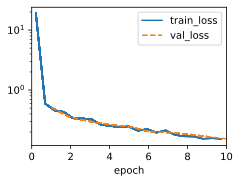

In [44]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=10, wd=0.001, lr=0.01)